In [1]:
import numpy as np
import os

In [2]:
cwd = './results/shunqing/'
files = os.listdir(cwd)
events = set(['_'.join(file.split('_')[:2]) for file in files])

In [3]:
errs = []
for event in events:
    true = np.load(os.path.join(cwd,event+'_true.npy'))
    pred = np.load(os.path.join(cwd,event+'_pred.npy'))
    true[...,1] = true[...,1] - true[...,-1]
    err = true[:,:,:-1] - pred
    errs.append(err)

In [9]:
true.shape

(514, 105, 4)

In [5]:
import matplotlib.pyplot as plt

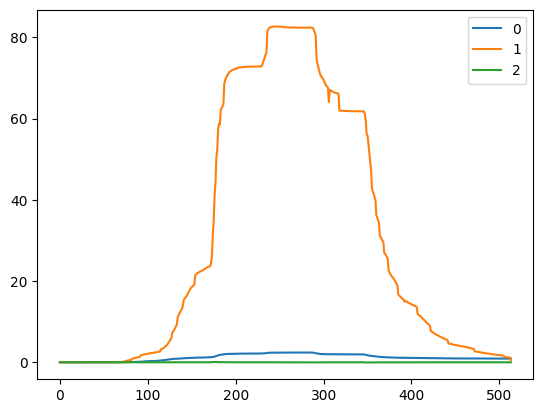

In [12]:
true = np.load(os.path.join(cwd,event+'_true.npy'))
for i in range(3):
    plt.plot(true.mean(axis=1)[:,i],label=i)
    plt.legend()

In [4]:
train_loss = np.load('./model/shunqing/train_loss.npy')
test_loss = np.load('./model/shunqing/train_loss.npy')


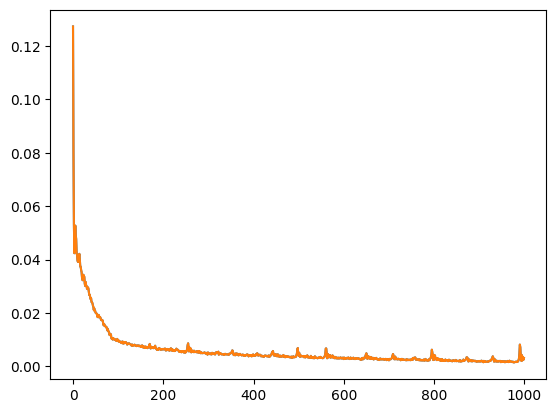

In [6]:
plt.plot(train_loss)
plt.plot(test_loss)